In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import copy

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
event_ID=0
##% REGION SELECTION
if event_ID==0:
    ###USA
    year=2020; month=np.arange(3,10); 
    latslice=slice(20,50); lonslice=slice(250,300)
    lon_conv=False
    flag='USA'
elif event_ID==1:
    ###ARGENTINA
    year=2020; month=(9,10,11,12,1,2)
    latslice=slice(-40,-25); lonslice=slice(290,310)
    lon_conv=False
    flag='ARG'
elif event_ID==2:
    ###AUSTRALIA
    year=2020; month=(9,10,11,12,1,2)
    latslice=slice(-35,-20); lonslice=slice(140,155)
    lon_conv=False
    flag='AUS'
elif event_ID==3:
    ###CHINA
    year=2020; month=np.arange(4,10)
    latslice=slice(20,35); lonslice=slice(100,120)
    lon_conv=False
    flag='CHN'
elif event_ID==4:
    ###EUROPE
    year=2020; month=np.arange(4,10)
    latslice=slice(35,55); lonslice=slice(-10,30)
    lon_conv=True
    flag='EUR'

In [3]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
models=['graphcast_','graphcast-oper_','pangu_','pangu-oper_','ifs_','sfno_','sfno-oper_']#'fcnv2_dawn','ifs']
labels=['graphcast','graphcast-oper','pangu','pangu-oper','ifs','sfno','sfno-oper']
references=[flag+'_era5_convseason_2020.nc',flag+'_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
figpath='/users/mfeldman/figs/pub/'+flag+'_'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#f3322f' #red
colors=[c2,c1,c3,c7,c6,c4,c5]#c5


/tmp/ipykernel_1124734/1195935541.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


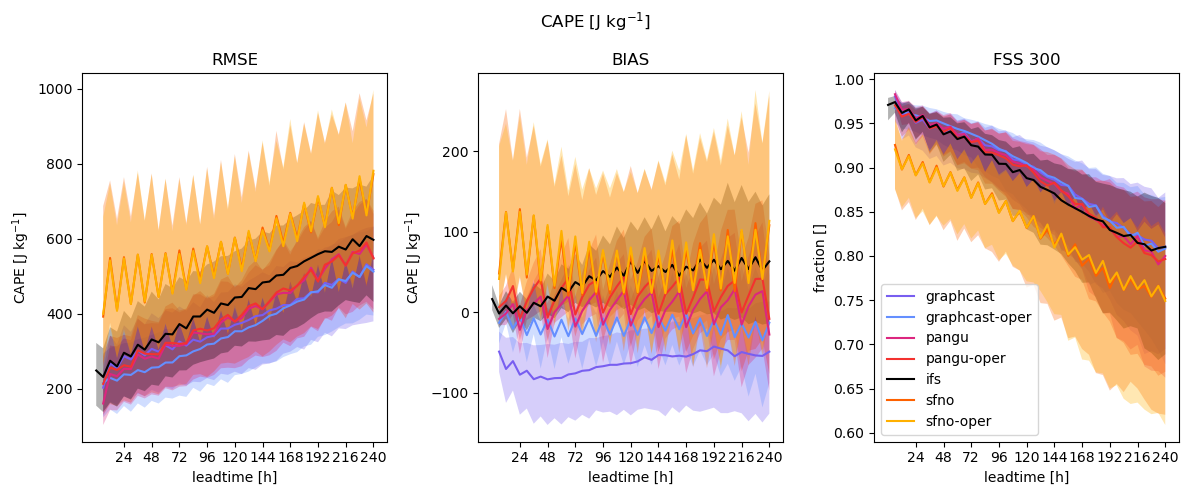

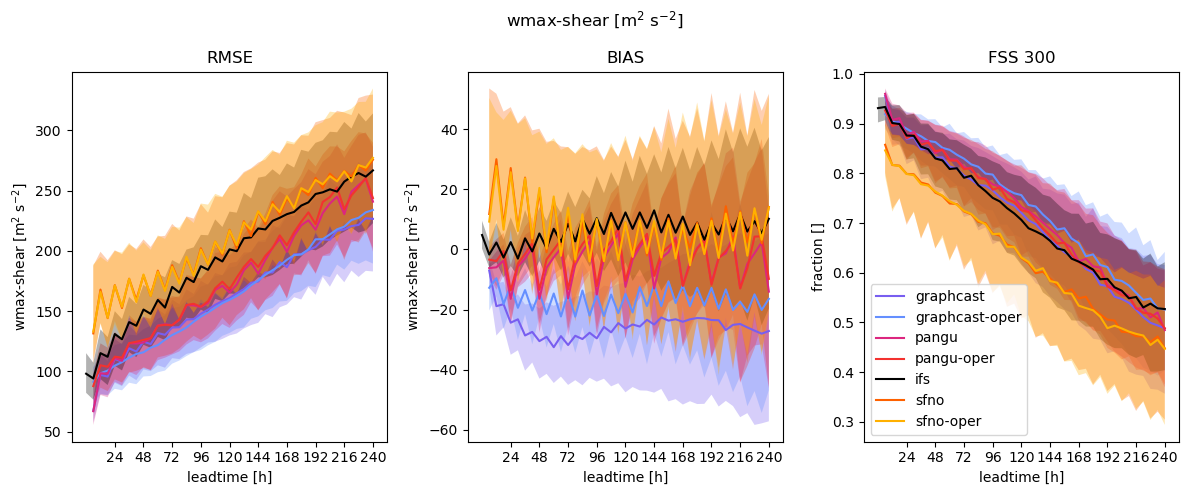

In [4]:
iis=[1,1,1,1,0,1,1]

for mm in range(2)[:]:
    var=['cape','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,300][mm]
    l2=[1000,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    fig,axes = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models))[:]:
        ii=iis[nn]
        model=models[nn]
        color=colors[nn]
        label=labels[nn]
        file=glob(datapath+model+var+'_eval_scores.nc')[0]
        scores=xr.open_dataset(file)#,engine='netcdf4')

        sal_s=scores.structure
        sal_a=scores.amplitude
        sal_l=scores.location

        rmse=scores.rmse
        bias=scores.bias
        fss_eval_300=scores.fss_low
        fss_eval_1000=scores.fss_high

        dt=scores.date
        ldt=len(scores.leadtime)

        
        

        axes[0].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(rmse,axis=1),c=color)
        axes[0].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(rmse,75,axis=1),
                              np.nanpercentile(rmse,25,axis=1),facecolor=color,alpha=0.3)
        axes[0].set_title('RMSE')
        axes[0].set_xlabel('leadtime [h]')
        axes[0].set_xticks(np.arange(24,258,24))
        axes[0].set_ylabel(tit)
        axes[1].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(bias,axis=1),c=color)
        axes[1].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(bias,75,axis=1),
                              np.nanpercentile(bias,25,axis=1),facecolor=color,alpha=0.3)
        axes[1].set_title('BIAS')
        axes[1].set_xlabel('leadtime [h]')
        axes[1].set_xticks(np.arange(24,258,24))
        axes[1].set_ylabel(tit)

        axes[2].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(fss_eval_300,axis=1),c=color,label=label)
        axes[2].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(fss_eval_300,75,axis=1),
                              np.nanpercentile(fss_eval_300,25,axis=1),facecolor=color,alpha=0.3)
        axes[2].set_title('FSS '+str(l1))
        axes[2].set_xlabel('leadtime [h]')
        axes[2].set_xticks(np.arange(24,258,24))
        axes[2].set_ylabel('fraction []')
        axes[2].legend()
        fig.suptitle(tit)
    
    
    
    fig.tight_layout()
    fig.show()
    fig.savefig(figpath+var+'_sum_scores_prctl_all.png')


/tmp/ipykernel_1124734/3092521109.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


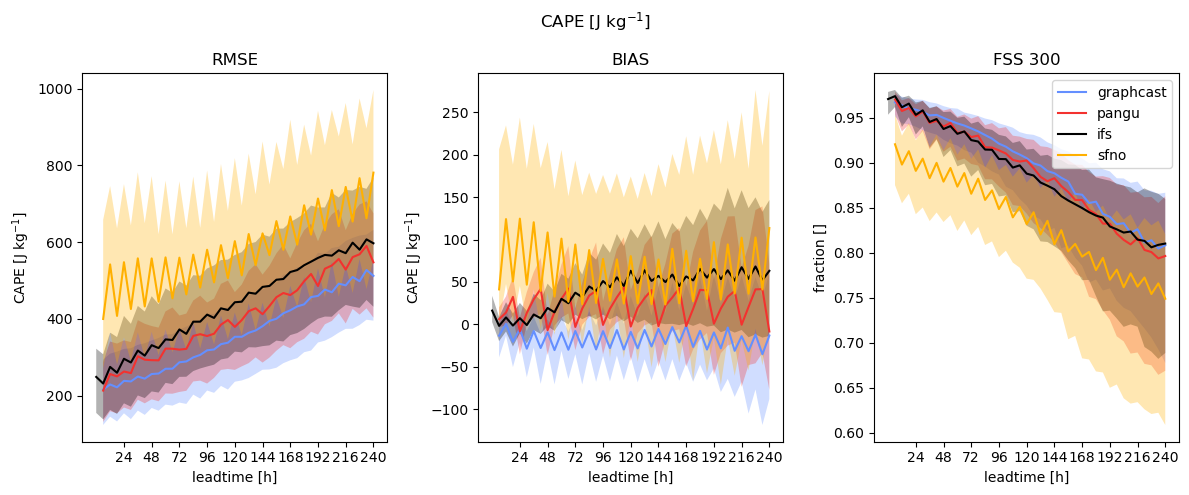

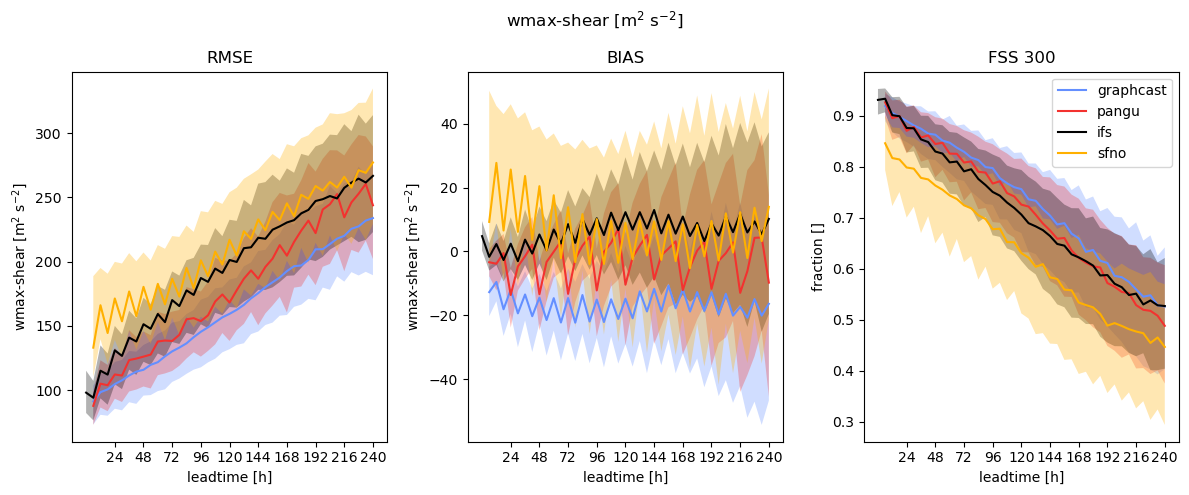

In [5]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
models=['graphcast-oper_','pangu-oper_','ifs_','sfno-oper_']#'fcnv2_dawn','ifs']
labels=['graphcast','pangu','ifs','sfno']
references=[flag+'_era5_convseason_2020.nc',flag+'_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
figpath='/users/mfeldman/figs/pub/'+flag+'_'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#f3322f' #red
colors=[c1,c7,c6,c5]#c5


iis=[1,1,0,1]

for mm in range(2)[:]:
    var=['cape','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,300][mm]
    l2=[1000,500][mm]
    f1=[1,-1,1,1,1,1][mm]
    fig,axes = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models))[:]:
        ii=iis[nn]
        model=models[nn]
        color=colors[nn]
        label=labels[nn]
        file=glob(datapath+model+var+'_eval_scores.nc')[0]
        scores=xr.open_dataset(file)#,engine='netcdf4')

        sal_s=scores.structure
        sal_a=scores.amplitude
        sal_l=scores.location

        rmse=scores.rmse
        bias=scores.bias
        fss_eval_300=scores.fss_low
        fss_eval_1000=scores.fss_high

        dt=scores.date
        ldt=len(scores.leadtime)

        
        

        axes[0].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(rmse,axis=1),c=color)
        axes[0].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(rmse,75,axis=1),
                              np.nanpercentile(rmse,25,axis=1),facecolor=color,alpha=0.3)
        axes[0].set_title('RMSE')
        axes[0].set_xlabel('leadtime [h]')
        axes[0].set_xticks(np.arange(24,258,24))
        axes[0].set_ylabel(tit)
        axes[1].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(bias,axis=1),c=color)
        axes[1].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(bias,75,axis=1),
                              np.nanpercentile(bias,25,axis=1),facecolor=color,alpha=0.3)
        axes[1].set_title('BIAS')
        axes[1].set_xlabel('leadtime [h]')
        axes[1].set_xticks(np.arange(24,258,24))
        axes[1].set_ylabel(tit)

        axes[2].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(fss_eval_300,axis=1),c=color,label=label)
        axes[2].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(fss_eval_300,75,axis=1),
                              np.nanpercentile(fss_eval_300,25,axis=1),facecolor=color,alpha=0.3)
        axes[2].set_title('FSS '+str(l1))
        axes[2].set_xlabel('leadtime [h]')
        axes[2].set_xticks(np.arange(24,258,24))
        axes[2].set_ylabel('fraction []')
        axes[2].legend()
        fig.suptitle(tit)
    
    
    
    fig.tight_layout()
    fig.show()
    fig.savefig(figpath+var+'_sum_scores_prctl_red.png')


/tmp/ipykernel_1124734/2941346330.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


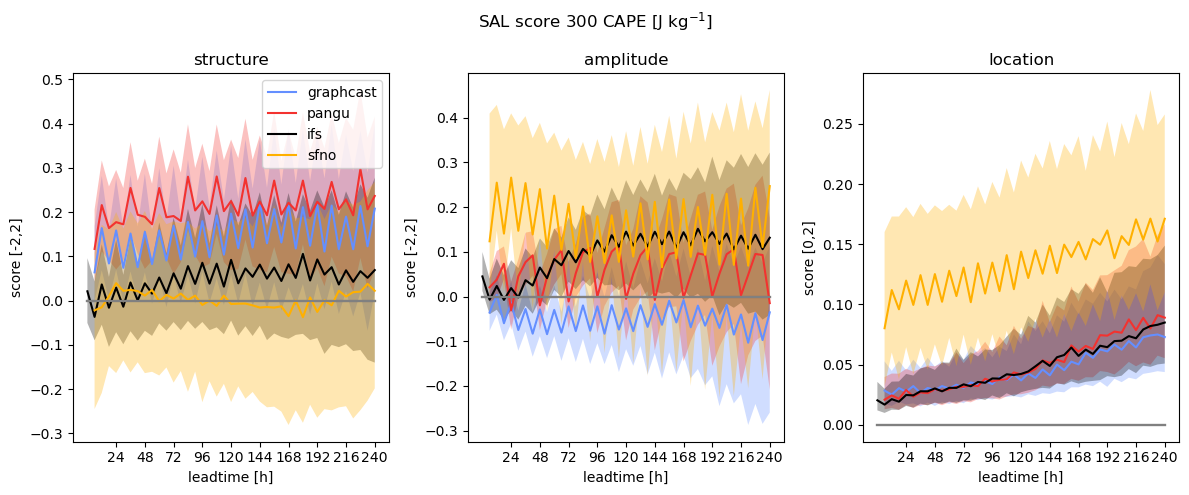

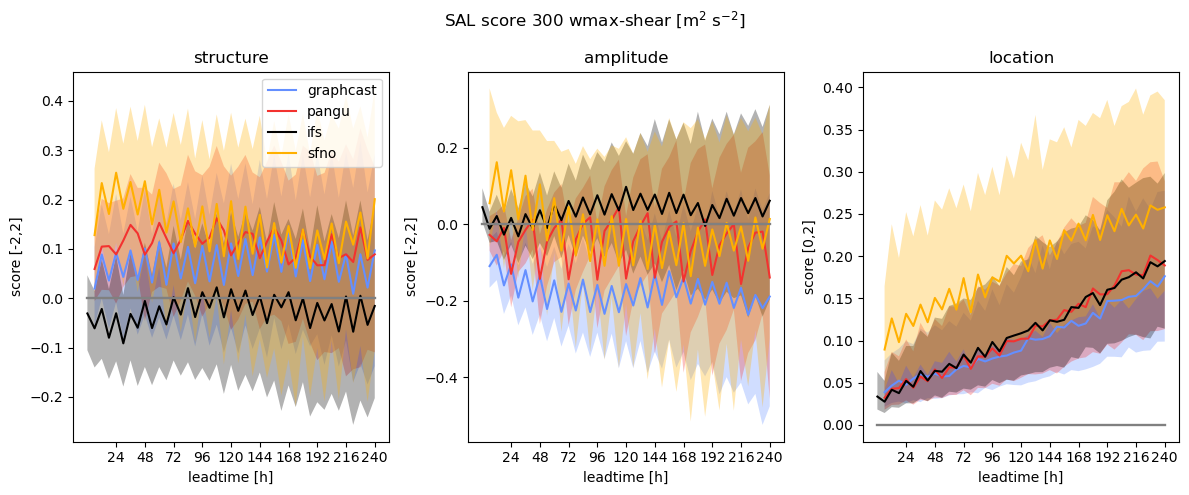

In [6]:


for mm in range(2)[:]:
    var=['cape','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300,300][mm]
    l2=[1000,500][mm]
    f1=[1,1][mm]
    fig2,axes2 = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models))[:]:
        ii=iis[nn]
        model=models[nn]
        color=colors[nn]
        label=labels[nn]
        file=glob(datapath+model+var+'_eval_scores.nc')[0]
        scores=xr.open_dataset(file)#,engine='netcdf4')

        sal_s=scores.structure
        sal_a=scores.amplitude
        sal_l=scores.location

        rmse=scores.rmse
        bias=scores.bias
        fss_eval_300=scores.fss_low
        fss_eval_1000=scores.fss_high

        dt=scores.date
        ldt=len(scores.leadtime)

        axes2[0].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(sal_s,axis=1),c=color,label=label)
        axes2[0].plot([0,240],np.zeros(2),c='grey')
        axes2[0].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(sal_s,75,axis=1),
                              np.nanpercentile(sal_s,25,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('structure')
        axes2[0].set_xlabel('leadtime [h]')
        axes2[0].set_xticks(np.arange(24,258,24))
        axes2[0].set_ylabel('score [-2,2]')
        axes2[0].legend()
        axes2[1].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(sal_a,axis=1),c=color,label=label)
        axes2[1].plot([0,240],np.zeros(2),c='grey')
        axes2[1].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(sal_a,75,axis=1),
                              np.nanpercentile(sal_a,25,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('amplitude')
        axes2[1].set_xlabel('leadtime [h]')
        axes2[1].set_xticks(np.arange(24,258,24))
        axes2[1].set_ylabel('score [-2,2]')
        #axes2[1].legend()
        axes2[2].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(sal_l,axis=1),c=color)
        axes2[2].plot([0,240],np.zeros(2),c='grey')
        axes2[2].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(sal_l,75,axis=1),
                              np.nanpercentile(sal_l,25,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('location')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_xticks(np.arange(24,258,24))
        axes2[2].set_ylabel('score [0,2]')
        fig2.suptitle('SAL score '+str(l1)+' '+tit)
    
    
    
    
    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_sal_scores_prctl.png')



/tmp/ipykernel_1124734/2965266510.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


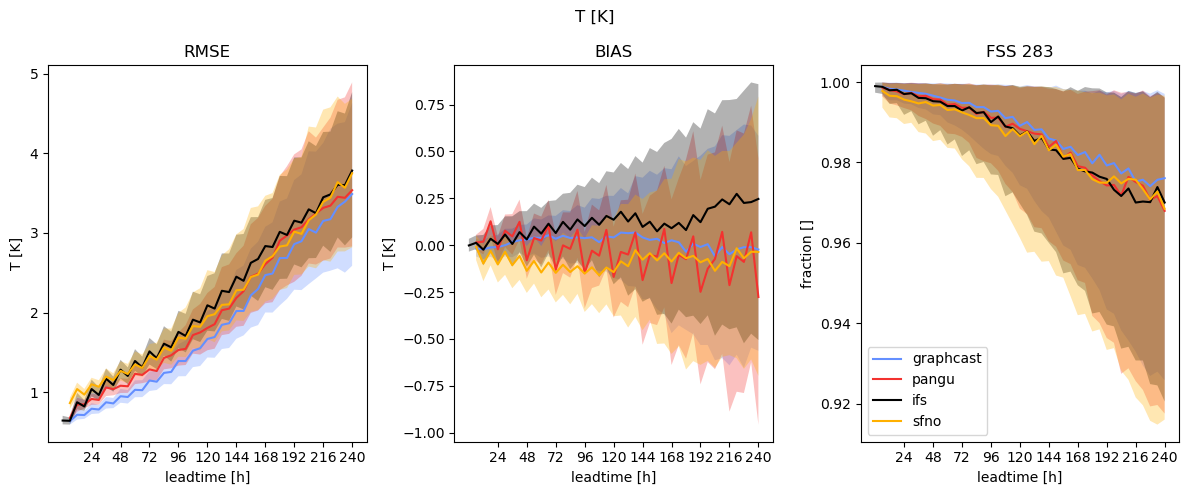

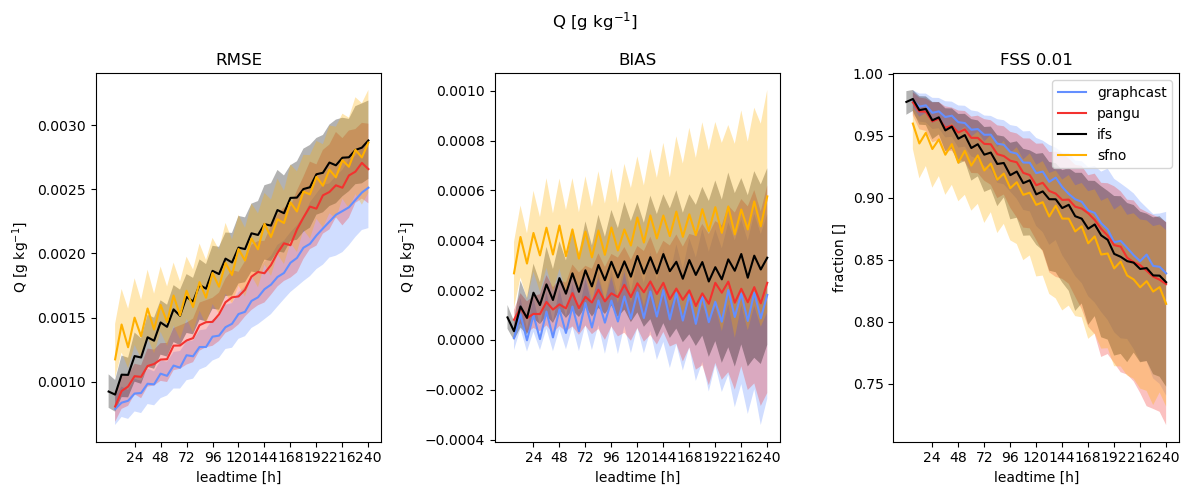

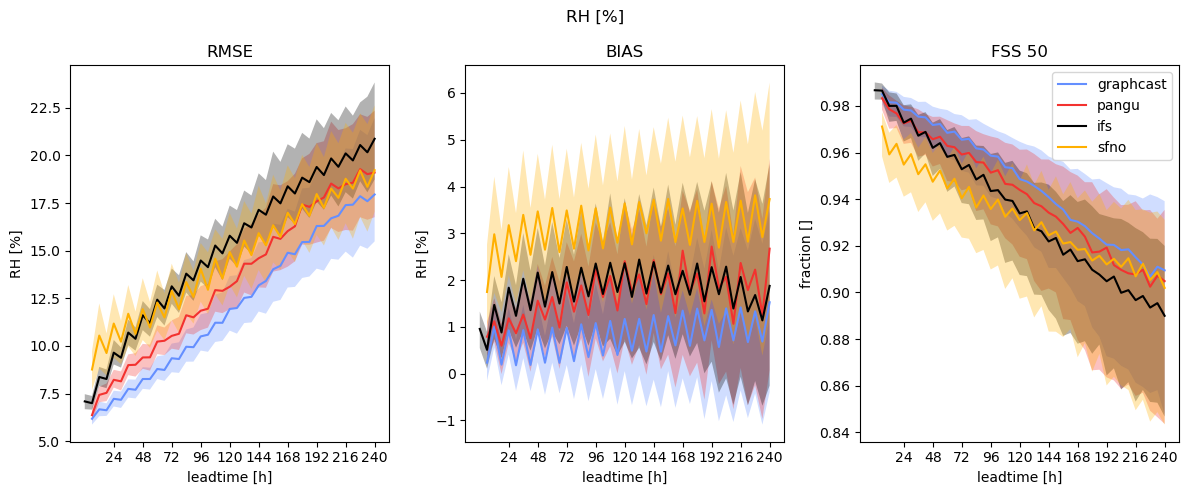

In [7]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
models=['graphcast-oper_','pangu-oper_','ifs_','sfno-oper_']#'fcnv2_dawn','ifs']
labels=['graphcast','pangu','ifs','sfno']
references=[flag+'_era5_convseason_2020.nc',flag+'_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
figpath='/users/mfeldman/figs/pub/'+flag+'_'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#f3322f' #red
colors=[c1,c7,c6,c5]#c5


iis=[1,1,0,1]

for mm in range(3)[:]:
    var=['t925','q925','r925'][mm]
    tit=['T [K]','Q [g kg$^{-1}$]','RH [%]'][mm]
    l1=[283,0.01,50][mm]
    l2=[293,0.05,90][mm]
    f1=[1,1,1][mm]
    fig,axes = plt.subplots(1,3,figsize=(12, 5))
    for nn in range(len(models))[:]:
        
        ii=iis[nn]
        model=models[nn]
        color=colors[nn]
        label=labels[nn]
        file=glob(datapath+model+var+'_eval_scores.nc')[0]
        scores=xr.open_dataset(file)#,engine='netcdf4')
        #if nn==3: scores=scores/10

        sal_s=scores.structure
        sal_a=scores.amplitude
        sal_l=scores.location

        rmse=scores.rmse
        bias=scores.bias
        fss_eval_300=scores.fss_low
        fss_eval_1000=scores.fss_high

        dt=scores.date
        ldt=len(scores.leadtime)

        
        

        axes[0].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(rmse,axis=1),c=color)
        axes[0].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(rmse,75,axis=1),
                              np.nanpercentile(rmse,25,axis=1),facecolor=color,alpha=0.3)
        axes[0].set_title('RMSE')
        axes[0].set_xlabel('leadtime [h]')
        axes[0].set_xticks(np.arange(24,258,24))
        axes[0].set_ylabel(tit)
        axes[1].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(bias,axis=1),c=color)
        axes[1].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(bias,75,axis=1),
                              np.nanpercentile(bias,25,axis=1),facecolor=color,alpha=0.3)
        axes[1].set_title('BIAS')
        axes[1].set_xlabel('leadtime [h]')
        axes[1].set_xticks(np.arange(24,258,24))
        axes[1].set_ylabel(tit)

        axes[2].plot(np.arange(ii,ldt+ii)*6,np.nanmedian(fss_eval_300,axis=1),c=color,label=label)
        axes[2].fill_between(np.arange(ii,ldt+ii)*6,np.nanpercentile(fss_eval_300,75,axis=1),
                              np.nanpercentile(fss_eval_300,25,axis=1),facecolor=color,alpha=0.3)
        axes[2].set_title('FSS '+str(l1))
        axes[2].set_xlabel('leadtime [h]')
        axes[2].set_xticks(np.arange(24,258,24))
        axes[2].set_ylabel('fraction []')
        axes[2].legend()
        fig.suptitle(tit)
    
    
    
    fig.tight_layout()
    fig.show()
    fig.savefig(figpath+var+'_sum_scores_prctl_red.png')
